[0, 1, 2, 3, 4, 5, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17]
uint8 16


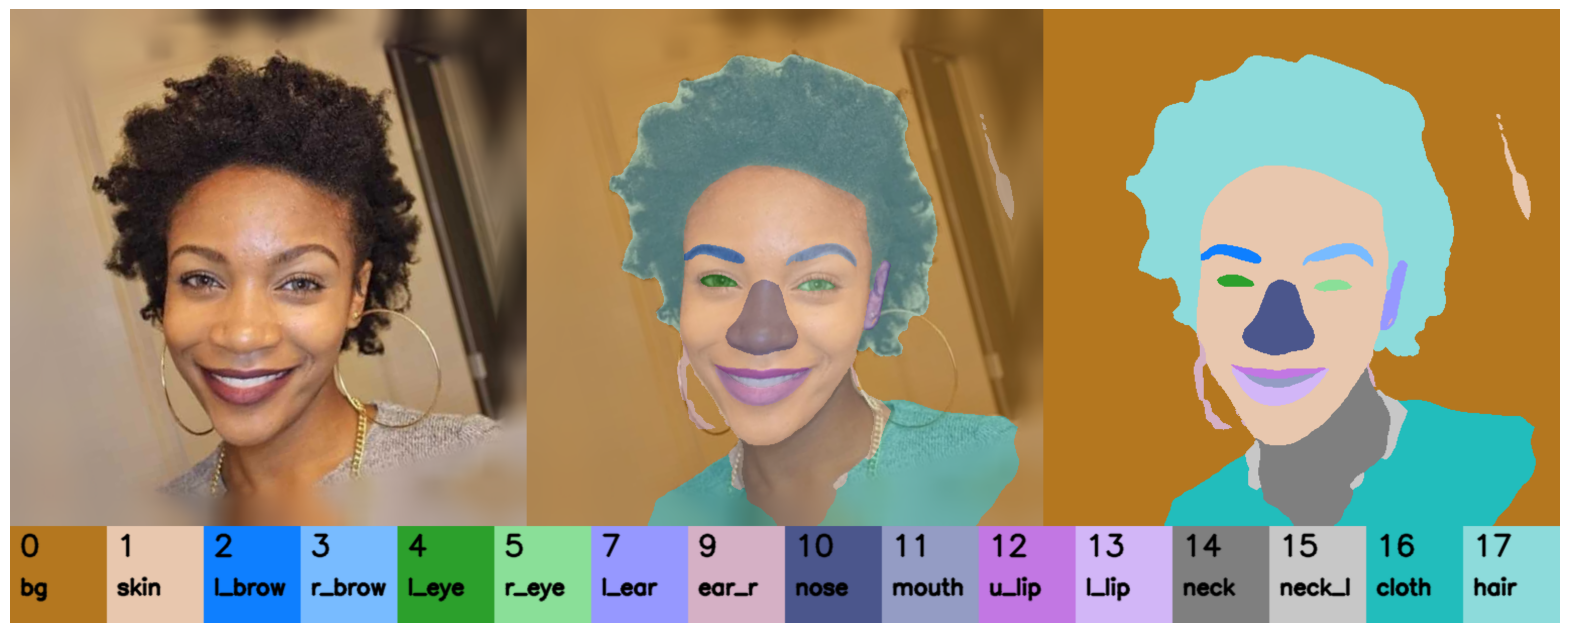

[0, 1, 2, 3, 4, 5, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17]
uint8 16


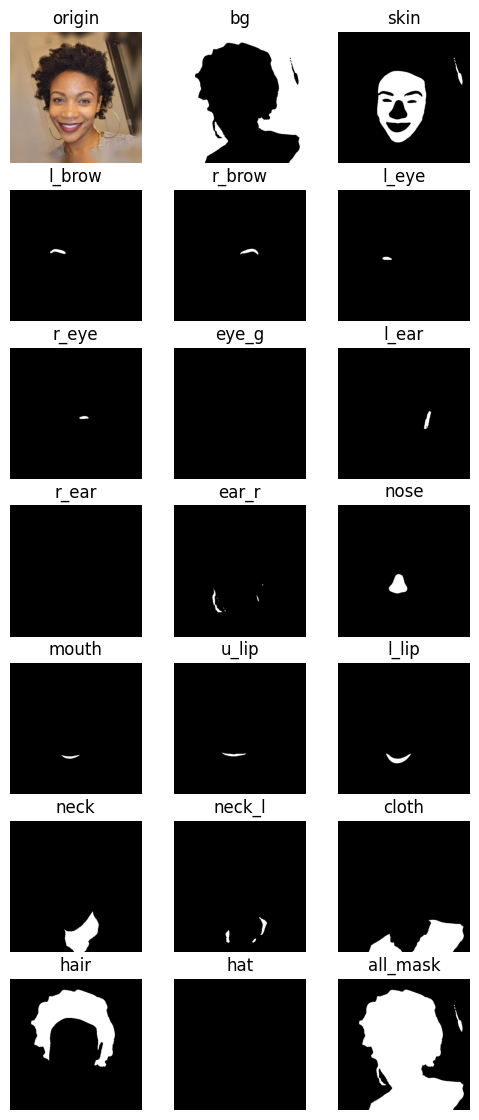

In [14]:
import cv2
from dpparser import HeadParser
from visualize.vis_2d import show_parsing_result, show_parsing_result_colorized

hed_par = HeadParser()
# img_path = "/home/chence/Research/3DHeadGen/DatProc/temp/parsing/man_head.jpg"
img_path = "/home/chence/Research/3DHeadGen/DatProc/temp/samples/samples_bv/head_images/000320_00.png"
img_data = cv2.imread(img_path)

ori_img = img_data.copy()
is_bgr = True

# fpp_sem = hed_par.run_fpp(hed_par.fpp_transform, hed_par.fpp_model,
#                           ori_img, is_bgr, False)
# ibug_sem03 = hed_par.run_ibug(hed_par.ibug_model_03, ori_img, is_bgr, False)
# ibug_sem04 = hed_par.run_ibug(hed_par.ibug_model_04, ori_img, is_bgr, False)
sem = hed_par(ori_img, is_bgr, False)
# sem = ibug_sem04
show_parsing_result_colorized(img_data[..., ::-1], sem, hed_par.label)
show_parsing_result(img_data[..., ::-1], sem, hed_par.label)